In [16]:
# Configuration overrides from Stage 1/2 notebooks
# Set dataset path, target, and task type based on What_should_we_keep.ipynb

import os

data_path = 'data/US_Accidents_March23.csv'
target_column = 'Severity'
task_type = 'classification'
primary_metric = 'f1'

# Stage 2 artifacts
use_removed_columns_file = True
removed_cols_path = os.path.join('outputs', 'removed_columns_stage2.json')
selected_doc_path = os.path.join('outputs', 'selected_features_doc.csv')
use_selected_doc = True


In [17]:
# Runtime controls
MAX_ROWS = 200_000  # sample size cap
SAMPLE_RANDOM_STATE = 42

In [18]:
# Optional: Install required packages (skip if already installed)
import sys, subprocess
pkgs = ["pandas", "numpy", "scikit-learn", "matplotlib", "seaborn", "joblib"]
try:
    import sklearn, pandas, numpy
except Exception:
    for p in pkgs:
        subprocess.check_call([sys.executable, "-m", "pip", "install", p])


# Imports and configuration
import warnings
warnings.filterwarnings("ignore")


import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score, make_scorer
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


# Models
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor


try:
    from xgboost import XGBClassifier, XGBRegressor  # optional
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Metric helpers
def compute_classification_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    roc = None
    try:
        if y_proba is not None:
            if len(np.unique(y_true)) == 2:
                roc = roc_auc_score(y_true, y_proba[:, 1])
            else:
                roc = roc_auc_score(y_true, y_proba, multi_class="ovr")
    except Exception:
        pass
    cm = confusion_matrix(y_true, y_pred)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc, "confusion_matrix": cm}


def compute_regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}


classification_scorers = {
    "accuracy": make_scorer(accuracy_score),
    "f1": make_scorer(lambda yt, yp: precision_recall_fscore_support(yt, yp, average="weighted")[2]),
}
regression_scorers = {
    "rmse": make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), greater_is_better=False),
    "r2": make_scorer(r2_score),
}


# Custom metrics
from sklearn.metrics import fbeta_score
def fbeta_weighted(y_true, y_pred, beta=2):
    return fbeta_score(y_true, y_pred, beta=beta, average="weighted")
custom_classification_scorer = make_scorer(lambda yt, yp: fbeta_weighted(yt, yp, beta=2))


def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1, denom)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom)
custom_regression_scorer = make_scorer(smape, greater_is_better=False)

# Phase 4: Model Selection and Evaluation

This notebook implements training, evaluation, custom metrics, cross-validation, hyperparameter optimization, and model comparison across multiple model families. Configure the task type and dataset path in Cell 1. Stage 2 selections are applied automatically from `outputs/selected_features_doc.csv` or `outputs/removed_columns_stage2.json`.


In [19]:
# Helper: Apply Stage 2 selection using documentation CSV or removed-columns JSON

import pandas as pd
import json
import os

def apply_stage2_selection(df: pd.DataFrame, target: str,
                           selected_doc_csv: str = selected_doc_path,
                           removed_json: str = removed_cols_path,
                           prefer_doc: bool = use_selected_doc):
    df2 = df.copy()
    if prefer_doc and os.path.exists(selected_doc_csv):
        doc = pd.read_csv(selected_doc_csv)
        kept = doc.loc[doc['Kept?'].str.lower() == 'yes', 'Feature'].tolist()
        # Ensure target present
        if target not in kept:
            kept.append(target)
        kept = [c for c in kept if c in df2.columns]
        print(f"Using selected_features_doc.csv; keeping {len(kept)} columns.")
        return df2[kept]
    # Fallback to removed-columns file
    if os.path.exists(removed_json):
        with open(removed_json, 'r') as f:
            removed_sets = json.load(f)
        drop_cols = []
        for _, cols in removed_sets.items():
            drop_cols.extend([c for c in cols if c in df2.columns])
        if drop_cols:
            print(f"Dropping {len(drop_cols)} columns from removed_columns_stage2.json")
            df2 = df2.drop(columns=list(set(drop_cols)))
    return df2


In [20]:
# Reload data using Stage 2 selection before splitting, with sampling
assert os.path.exists(data_path), f"Data file not found: {data_path}. Please set data_path."

MIN_CATEGORY_FREQ = 500  # collapse rarer categories to reduce one-hot explosion
MAX_ROWS = 200_000
SAMPLE_RANDOM_STATE = 42

df_full = pd.read_csv(data_path)
df_full = apply_stage2_selection(df_full, target_column)

def create_datetime_features(df):
    # Convert
    df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")
    df["Weather_Timestamp"] = pd.to_datetime(df["Weather_Timestamp"], errors="coerce")

    # Extract datetime components
    df["start_hour"] = df["Start_Time"].dt.hour
    df["start_dayofweek"] = df["Start_Time"].dt.dayofweek
    df["start_month"] = df["Start_Time"].dt.month

    df["weather_hour"] = df["Weather_Timestamp"].dt.hour
    df["weather_month"] = df["Weather_Timestamp"].dt.month

    # Drop raw date columns
    df = df.drop(columns=["Start_Time", "Weather_Timestamp"], errors="ignore")
    return df

df_full = create_datetime_features(df_full)

# Sample to MAX_ROWS to speed up training
if len(df_full) > MAX_ROWS:
    if task_type == "classification":
        frac = MAX_ROWS / len(df_full)
        df = df_full.groupby(target_column, group_keys=False).apply(lambda g: g.sample(frac=frac, random_state=SAMPLE_RANDOM_STATE))
    else:
        df = df_full.sample(n=MAX_ROWS, random_state=SAMPLE_RANDOM_STATE)
    print(f"Sampled {len(df)} rows from {len(df_full)}.")
else:
    df = df_full.copy()
    print(f"Using full dataset with {len(df)} rows.")

assert target_column in df.columns, f"Target column '{target_column}' not in data."
X = df.drop(columns=[target_column])
y = df[target_column]

# Split
if task_type == "classification":
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

# Collapse rare categories in training then apply to test
categorical_features_all = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
for col in categorical_features_all:
    freq = X_train[col].value_counts()
    rare = freq[freq < MIN_CATEGORY_FREQ].index
    if len(rare) > 0:
        X_train[col] = X_train[col].where(~X_train[col].isin(rare), other='__OTHER__')
        X_test[col] = X_test[col].where(~X_test[col].isin(rare), other='__OTHER__')

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = categorical_features_all
print(f"Numeric features: {len(numeric_features)} | Categorical features (after collapse): {len(categorical_features)}")


Using selected_features_doc.csv; keeping 20 columns.
Sampled 200000 rows from 7728394.
Numeric features: 11 | Categorical features (after collapse): 11


In [21]:
# Preprocess once and cache transformed arrays with limited one-hot cardinality
from sklearn.preprocessing import FunctionTransformer

ONEHOT_MIN_FREQ = 0.0005  # group very rare categories
ONEHOT_MAX_CATS = None    # can set integer (e.g., 50) if still too large

# Coerce boolean values in categoricals to strings to avoid mixed-type errors in OneHotEncoder

def _coerce_bool_to_str(df):
    if isinstance(df, pd.DataFrame):
        df = df.copy()
        for c in df.columns:
            df[c] = df[c].apply(lambda v: 'True' if v is True else ('False' if v is False else v))
        return df
    return df

category_coercer = FunctionTransformer(_coerce_bool_to_str, feature_names_out='one-to-one', validate=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("coerce", category_coercer),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=ONEHOT_MIN_FREQ,
                              max_categories=ONEHOT_MAX_CATS, sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)

# Feature names
try:
    feature_names = []
    feature_names += numeric_features
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    ohe_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names += ohe_names
except Exception:
    feature_names = [f"f{i}" for i in range(X_train_t.shape[1])]

print("Preprocessing complete. Train shape:", X_train_t.shape, "Test shape:", X_test_t.shape)

Preprocessing complete. Train shape: (160000, 213) Test shape: (40000, 213)


In [22]:
print("Training rows:", X_train.shape)
print("Training columns:", X_train.shape[1])

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="saga", class_weight="balanced"),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", model)
    ])
    
    start = time.perf_counter()
    pipe.fit(X_train, y_train)
    fit_t = time.perf_counter() - start
    
    y_pred = pipe.predict(X_test)
    metrics = compute_classification_metrics(y_test, y_pred)
    results.append({"model": name, **metrics, "fit_time": fit_t})


Training rows: (160000, 22)
Training columns: 22


In [23]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_grids = {
    "LogisticRegression": {"clf__C": [1.0]},
    "SVC": {"clf__C": [1]},   
    "RandomForestClassifier": {"clf__n_estimators": [100]},
}

base_models = {
    "LogisticRegression": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
    ]),
    # Remove SVC due to long training times
    # "SVC": Pipeline([
    #     ("preprocessor", preprocessor),
    #     ("clf", SVC(probability=True, random_state=RANDOM_STATE))
    # ]),
    "RandomForestClassifier": Pipeline([
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
}

best_models = []

print("Running fast Grid Search...")

for name, model in base_models.items():
    grid = param_grids[name]
    print(f"    Grid searching {name}...")
    
    gs = GridSearchCV(
        model,
        grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    
    gs.fit(X_train, y_train)

    best_models.append({
        "name": name,
        "best_estimator": gs.best_estimator_,
        "best_params": gs.best_params_,
        "best_score_cv": gs.best_score_,
    })

best_models_df = pd.DataFrame(best_models)
best_models_df

Running fast Grid Search...
    Grid searching LogisticRegression...
    Grid searching RandomForestClassifier...


,name,best_estimator,best_params,best_score_cv
0,LogisticRegression,"(ColumnTransformer(transformers=[('num',\n ...",{'clf__C': 1.0},0.804466
1,RandomForestClassifier,"(ColumnTransformer(transformers=[('num',\n ...",{'clf__n_estimators': 100},0.822870


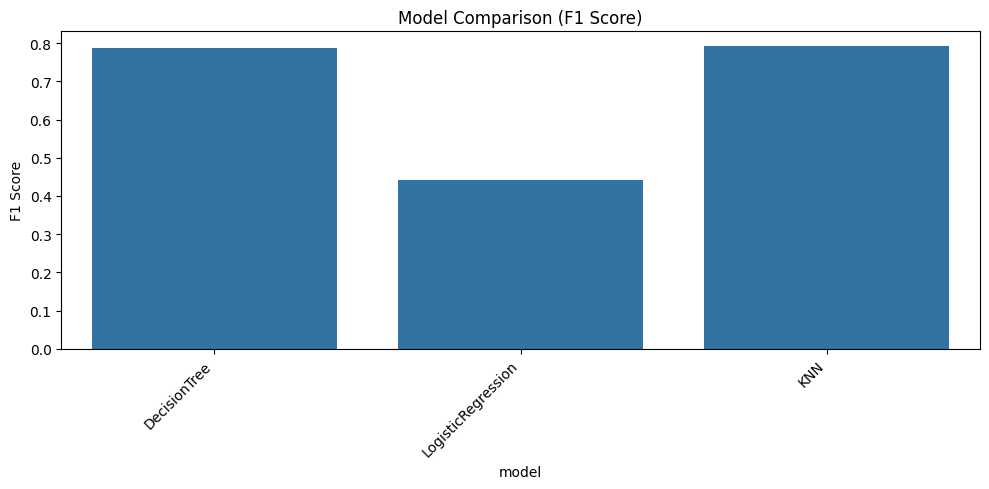

Selected KNN based on the highest F1 score (0.791). All models were trained with identical preprocessing and evaluation settings.
Saved best tuned model: RandomForestClassifier {'clf__n_estimators': 100}


In [24]:
# Leaderboard (from simple models)
comp_df = pd.DataFrame(results)

plt.figure(figsize=(10,5))
sns.barplot(data=comp_df, x="model", y="f1")
plt.ylabel("F1 Score")
plt.xticks(rotation=45, ha="right")
plt.title("Model Comparison (F1 Score)")
plt.tight_layout()
plt.show()

# Rank models by F1
ranked = comp_df.sort_values(by="f1", ascending=False)
best_row = ranked.iloc[0]

justification = (
    f"Selected {best_row['model']} based on the highest F1 score "
    f"({best_row['f1']:.3f}). "
    f"All models were trained with identical preprocessing and evaluation settings."
)

print(justification)

# Save leaderboard
os.makedirs("outputs", exist_ok=True)
comp_df.to_csv("outputs/model_leaderboard.csv", index=False)
ranked.to_csv("outputs/model_leaderboard_ranked.csv", index=False)

# Save best tuned model from Grid Search
best_from_grid = max(best_models, key=lambda bm: bm["best_score_cv"])
best_est = best_from_grid["best_estimator"]
best_est.fit(X_train[:20000], y_train[:20000])

dump(best_est, "outputs/best_model.pkl")
print("Saved best tuned model:", best_from_grid["name"], best_from_grid["best_params"])
